In [ ]:
##If you are running this notebook in Google Colab, you can comment/ignore the next two cells

In [1]:
!python -m ipykernel install --user --name=pyspark_env --display-name "Python (pyspark_env)"

Installed kernelspec pyspark_env in C:\Users\user\AppData\Roaming\jupyter\kernels\pyspark_env


In [ ]:
##Click on kernel, change kernel and chosse python(pyspark_env)

In [2]:
from pyspark.sql.functions import col, sum as spark_sum
from pyspark.sql.functions import trim, lower
from pyspark.sql.functions import concat_ws
from pyspark.sql.functions import to_date, to_timestamp
from pyspark.sql.functions import desc
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import substring
from pyspark.sql import functions as F

In [3]:
from pyspark.sql import SparkSession

In [4]:
# create sparksession
spark = SparkSession.builder.appName("customer_seg2").getOrCreate()

###0. Loading the data

In [5]:
# file path
file_path = "../data/raw/"
df_offers = spark.read.json(file_path + 'offers.json')
df_profile = spark.read.json(file_path + 'profile.json')
df_trans = spark.read.json(file_path + 'transactions.json')

### 1. Cleaning data

First, we need to load the `.json` file and check datatypes. Then, we need to search for `Null` values and clean or manipulate the values.

#### 1.1 Offers data

In [6]:
df_offers.printSchema()

root
 |-- channels: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- discount_value: long (nullable = true)
 |-- duration: double (nullable = true)
 |-- id: string (nullable = true)
 |-- min_value: long (nullable = true)
 |-- offer_type: string (nullable = true)



In [7]:
df_offers.dtypes

[('channels', 'array<string>'),
 ('discount_value', 'bigint'),
 ('duration', 'double'),
 ('id', 'string'),
 ('min_value', 'bigint'),
 ('offer_type', 'string')]

In [8]:
df_offers.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in df_offers.columns]).show()##count null values in each column

+--------+--------------+--------+---+---------+----------+
|channels|discount_value|duration| id|min_value|offer_type|
+--------+--------------+--------+---+---------+----------+
|       0|             0|       0|  0|        0|         0|
+--------+--------------+--------+---+---------+----------+



In [9]:
df_offers = df_offers.withColumn("id", trim(col("id")))##remove white spaces
df_offers = df_offers.withColumn("offer_type", trim(col("offer_type")))
df_offers = df_offers.withColumn("channels", trim(concat_ws(", ", "channels")))##extract channels

In [10]:
df_offers.show(5)

+--------------------+--------------+--------+--------------------+---------+-------------+
|            channels|discount_value|duration|                  id|min_value|   offer_type|
+--------------------+--------------+--------+--------------------+---------+-------------+
|email, mobile, so...|            10|     7.0|ae264e3637204a6fb...|       10|         bogo|
|web, email, mobil...|            10|     5.0|4d5c57ea9a6940dd8...|       10|         bogo|
|  web, email, mobile|             0|     4.0|3f207df678b143eea...|        0|informational|
|  web, email, mobile|             5|     7.0|9b98b8c7a33c4b65b...|        5|         bogo|
|          web, email|             5|    10.0|0b1e1539f2cc45b7b...|       20|     discount|
+--------------------+--------------+--------+--------------------+---------+-------------+
only showing top 5 rows



In [11]:
df_offers.select("channels").distinct().show(truncate = False)

+--------------------------+
|channels                  |
+--------------------------+
|web, email, mobile        |
|web, email, mobile, social|
|email, mobile, social     |
|web, email                |
+--------------------------+



There are 10 offers in total:

In [12]:
df_offers.select("id").distinct().count()

10

In [13]:
df_offers = df_offers.withColumnRenamed("id", "offer_id")##change column name

In [14]:
df_offers.select(["discount_value", "duration", "min_value"]).summary().show()##check statistics about numeric features

+-------+-----------------+------------------+-----------------+
|summary|   discount_value|          duration|        min_value|
+-------+-----------------+------------------+-----------------+
|  count|               10|                10|               10|
|   mean|              4.2|               6.5|              7.7|
| stddev|3.583914681524163|2.3213980461973533|5.831904586934796|
|    min|                0|               3.0|                0|
|    25%|                2|               5.0|                5|
|    50%|                3|               7.0|                7|
|    75%|                5|               7.0|               10|
|    max|               10|              10.0|               20|
+-------+-----------------+------------------+-----------------+



#### 1.2 Profile data

In [15]:
df_profile.count()

17000

In [16]:
df_profile.show(5)

+---+-----------------+------+--------------------+-------------+
|age|credit_card_limit|gender|                  id|registered_on|
+---+-----------------+------+--------------------+-------------+
|118|             NULL|  NULL|68be06ca386d4c319...|     20170212|
| 55|         112000.0|     F|0610b486422d4921a...|     20170715|
|118|             NULL|  NULL|38fe809add3b4fcf9...|     20180712|
| 75|         100000.0|     F|78afa995795e4d85b...|     20170509|
|118|             NULL|  NULL|a03223e636434f42a...|     20170804|
+---+-----------------+------+--------------------+-------------+
only showing top 5 rows



In [17]:
df_profile.dtypes

[('age', 'bigint'),
 ('credit_card_limit', 'double'),
 ('gender', 'string'),
 ('id', 'string'),
 ('registered_on', 'string')]

In [18]:
df_profile.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in df_profile.columns]).show()##count null values

+---+-----------------+------+---+-------------+
|age|credit_card_limit|gender| id|registered_on|
+---+-----------------+------+---+-------------+
|  0|             2175|  2175|  0|            0|
+---+-----------------+------+---+-------------+



In [19]:
df_profile.groupBy("gender").count().show(n=17000)##count occurrences of each type in column gender

+------+-----+
|gender|count|
+------+-----+
|     F| 6129|
|  NULL| 2175|
|     M| 8484|
|     O|  212|
+------+-----+



We need to check if the rows where gender is null are the same where credit_card_limit is null.

In [20]:

df_profile2 = df_profile.withColumn("row_idx", monotonically_increasing_id())##create index for rows

In [21]:
df_nnula = df_profile2.filter(df_profile.gender.isNotNull())##filter nonnull genders


In [22]:
df_nnula_index = df_nnula.select("row_idx").collect()

In [23]:
df_nnulacc = df_profile2.filter(df_profile.credit_card_limit.isNotNull())

In [24]:
df_nnulacc_index = df_nnulacc.select("row_idx").collect()

In [25]:
df_nnulacc_index == df_nnula_index

True

The conclusion is that where gender is Null, credit_card_limit is Null. Then we are going to filter these rows.

In [26]:
df_profile_filtered = df_profile.filter(df_profile.gender.isNotNull())##remove null gender (and null credit_card consequentely)

We also have to check if the values for age are reasonable.

In [27]:
df_profile_filtered.filter(df_profile_filtered.age > 100).count()

5

In [28]:
df_profile_filtered = df_profile_filtered.filter(df_profile_filtered.age <= 100)

In [29]:
df_profile_filtered.show(5)

+---+-----------------+------+--------------------+-------------+
|age|credit_card_limit|gender|                  id|registered_on|
+---+-----------------+------+--------------------+-------------+
| 55|         112000.0|     F|0610b486422d4921a...|     20170715|
| 75|         100000.0|     F|78afa995795e4d85b...|     20170509|
| 68|          70000.0|     M|e2127556f4f64592b...|     20180426|
| 65|          53000.0|     M|389bc3fa690240e79...|     20180209|
| 58|          51000.0|     M|2eeac8d8feae4a8ca...|     20171111|
+---+-----------------+------+--------------------+-------------+
only showing top 5 rows



We need to check if the id's are unique.

In [30]:
df_profile_filtered.select('id').distinct().count(), df_profile_filtered.count()

(14820, 14820)

We also need to check if the credit_card_limit contains reasonable values.

In [31]:
df_profile_filtered.agg({"credit_card_limit": "max"}).collect(), df_profile_filtered.agg({"credit_card_limit": "min"}).collect()

([Row(max(credit_card_limit)=120000.0)], [Row(min(credit_card_limit)=30000.0)])

In [32]:
df2 = df_profile_filtered.withColumnRenamed("id", "client_id")

#### 1.3 Transactions data

In [33]:
df_trans.show(5)

+--------------------+--------------+---------------------+--------------------+
|          account_id|         event|time_since_test_start|               value|
+--------------------+--------------+---------------------+--------------------+
|78afa995795e4d85b...|offer received|                  0.0|{NULL, 9b98b8c7a3...|
|a03223e636434f42a...|offer received|                  0.0|{NULL, 0b1e1539f2...|
|e2127556f4f64592b...|offer received|                  0.0|{NULL, 2906b810c7...|
|8ec6ce2a7e7949b1b...|offer received|                  0.0|{NULL, fafdcd668e...|
|68617ca6246f4fbc8...|offer received|                  0.0|{NULL, 4d5c57ea9a...|
+--------------------+--------------+---------------------+--------------------+
only showing top 5 rows



In [34]:
df_trans.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in df_trans.columns]).show()

+----------+-----+---------------------+-----+
|account_id|event|time_since_test_start|value|
+----------+-----+---------------------+-----+
|         0|    0|                    0|    0|
+----------+-----+---------------------+-----+



In [35]:
df_trans.dtypes

[('account_id', 'string'),
 ('event', 'string'),
 ('time_since_test_start', 'double'),
 ('value',
  'struct<amount:double,offer id:string,offer_id:string,reward:double>')]

In [36]:
df_trans.select('account_id').distinct().count()##counting how many clients

17000

In [37]:
df_trans.count()##counting how many transactions

306534

We are going to consider only the transactions related to the filtered id's in the previous section.

In [38]:
ids = df2.select("client_id").collect()
id_list = [row.client_id for row in ids]

In [39]:
df_trans = df_trans.filter(col('account_id').isin(id_list))

In [40]:
df_trans.count()

272664

In [41]:
df_trans.select('account_id').distinct().count(), df2.count()

(14820, 14820)

In [42]:
df_trans.dtypes

[('account_id', 'string'),
 ('event', 'string'),
 ('time_since_test_start', 'double'),
 ('value',
  'struct<amount:double,offer id:string,offer_id:string,reward:double>')]

As we can see above, in the column value there is a key 'offer id' that we need to correct.

In [43]:
df_trans = df_trans.withColumn("value", F.struct(F.col("value.amount").alias("amount"),
        F.col("value.offer id").alias("offer_id_correct"),
        F.col("value.offer_id").alias("offer_id"),
        F.col("value.reward").alias("reward")))

Now, we need to check if there are more than one nonnull value in the value column.

In [44]:
possible_values = ['amount', 'offer_id_correct', 'offer_id', 'reward']

non_null_count = sum(F.when(F.col(f"value.{field}").isNotNull(), 1).otherwise(0) for field in possible_values)##count nulls in value column

df_with_count = df_trans.withColumn("non_null_count", non_null_count) ##create new df with null count


df_result = df_with_count.withColumn("only_one_non_null", F.col("non_null_count") == 1)

df_result.select("value", "only_one_non_null").show()

+--------------------+-----------------+
|               value|only_one_non_null|
+--------------------+-----------------+
|{NULL, 9b98b8c7a3...|             true|
|{NULL, 2906b810c7...|             true|
|{NULL, f19421c1d4...|             true|
|{NULL, 3f207df678...|             true|
|{NULL, 0b1e1539f2...|             true|
|{NULL, 0b1e1539f2...|             true|
|{NULL, ae264e3637...|             true|
|{NULL, 3f207df678...|             true|
|{NULL, 0b1e1539f2...|             true|
|{NULL, fafdcd668e...|             true|
|{NULL, 0b1e1539f2...|             true|
|{NULL, 9b98b8c7a3...|             true|
|{NULL, ae264e3637...|             true|
|{NULL, 2906b810c7...|             true|
|{NULL, 9b98b8c7a3...|             true|
|{NULL, 4d5c57ea9a...|             true|
|{NULL, 2298d6c36e...|             true|
|{NULL, f19421c1d4...|             true|
|{NULL, ae264e3637...|             true|
|{NULL, 9b98b8c7a3...|             true|
+--------------------+-----------------+
only showing top

In [45]:
df_result.groupBy('only_one_non_null').count().show()

+-----------------+------+
|only_one_non_null| count|
+-----------------+------+
|             true|240232|
|            false| 32432|
+-----------------+------+



There are 32432 rows where more than one value is nonnull. Let's understand what are these occurrences.

In [46]:
df_result.filter(df_result.only_one_non_null == False).show(5, truncate=False)

+--------------------------------+---------------+---------------------+----------------------------------------------------+--------------+-----------------+
|account_id                      |event          |time_since_test_start|value                                               |non_null_count|only_one_non_null|
+--------------------------------+---------------+---------------------+----------------------------------------------------+--------------+-----------------+
|9fa9ae8f57894cc9a3b8a9bbe0fc1b2f|offer completed|0.0                  |{NULL, NULL, 2906b810c7d4411798c6938adc9daaa5, 2.0} |2             |false            |
|fe97aa22dd3e48c8b143116a8403dd52|offer completed|0.0                  |{NULL, NULL, fafdcd668e3743c1bb461111dcafc2a4, 2.0} |2             |false            |
|629fc02d56414d91bca360decdfa9288|offer completed|0.0                  |{NULL, NULL, 9b98b8c7a33c4b65b9aebfe6a799e6d9, 5.0} |2             |false            |
|676506bad68e4161b9bbaffeb039626b|offer comple

In [47]:
df_result.filter((df_result.value.offer_id.isNotNull()) & (df_result.value.offer_id_correct.isNull()) & (df_result.value.amount.isNull()) & (df_result.value.reward.isNotNull())).count()

32432

In [48]:
df_result.filter((df_result.value.offer_id.isNull()) & (df_result.value.offer_id_correct.isNotNull()) & (df_result.value.amount.isNull()) & (df_result.value.reward.isNull())).count()

116322

In [49]:
df_result.filter((df_result.value.offer_id.isNull()) & (df_result.value.offer_id_correct.isNull()) & (df_result.value.amount.isNotNull()) & (df_result.value.reward.isNull())).count()

123910

We can conclude that there are 3 types of values:
- only offer_id_correct is nonnull;
- only amount is nonnull;
-  only offer_id and reward are nonnull.

In [50]:
32432+116322+123910

272664

In order to correct this problem, we are going to turn the struct value into 4 new columns.

In [51]:
df_new = df_trans.select('account_id', 'event', 'time_since_test_start', "value.offer_id_correct", "value.offer_id", "value.reward", 'value.amount')##create columns for each key in struc

In [52]:
df_new.show(5)

+--------------------+--------------+---------------------+--------------------+--------+------+------+
|          account_id|         event|time_since_test_start|    offer_id_correct|offer_id|reward|amount|
+--------------------+--------------+---------------------+--------------------+--------+------+------+
|78afa995795e4d85b...|offer received|                  0.0|9b98b8c7a33c4b65b...|    NULL|  NULL|  NULL|
|e2127556f4f64592b...|offer received|                  0.0|2906b810c7d441179...|    NULL|  NULL|  NULL|
|389bc3fa690240e79...|offer received|                  0.0|f19421c1d4aa40978...|    NULL|  NULL|  NULL|
|2eeac8d8feae4a8ca...|offer received|                  0.0|3f207df678b143eea...|    NULL|  NULL|  NULL|
|aa4862eba776480b8...|offer received|                  0.0|0b1e1539f2cc45b7b...|    NULL|  NULL|  NULL|
+--------------------+--------------+---------------------+--------------------+--------+------+------+
only showing top 5 rows



As we can see, the columns offer_id and offfer_id_correct are now redundant.

In [53]:
df_with_true = df_new.withColumn("true_offer_id", F.when(
        F.col("offer_id_correct").isNotNull() & F.col("offer_id").isNull(),
        F.col("offer_id_correct")
    ).when(
        F.col("offer_id_correct").isNull() & F.col("offer_id").isNotNull(),
        F.col("offer_id")
    )
)

df_with_true.show(5)

+--------------------+--------------+---------------------+--------------------+--------+------+------+--------------------+
|          account_id|         event|time_since_test_start|    offer_id_correct|offer_id|reward|amount|       true_offer_id|
+--------------------+--------------+---------------------+--------------------+--------+------+------+--------------------+
|78afa995795e4d85b...|offer received|                  0.0|9b98b8c7a33c4b65b...|    NULL|  NULL|  NULL|9b98b8c7a33c4b65b...|
|e2127556f4f64592b...|offer received|                  0.0|2906b810c7d441179...|    NULL|  NULL|  NULL|2906b810c7d441179...|
|389bc3fa690240e79...|offer received|                  0.0|f19421c1d4aa40978...|    NULL|  NULL|  NULL|f19421c1d4aa40978...|
|2eeac8d8feae4a8ca...|offer received|                  0.0|3f207df678b143eea...|    NULL|  NULL|  NULL|3f207df678b143eea...|
|aa4862eba776480b8...|offer received|                  0.0|0b1e1539f2cc45b7b...|    NULL|  NULL|  NULL|0b1e1539f2cc45b7b...|


In [54]:
df_trans = df_with_true.drop('offer_id_correct')##drop useless coluns
df_trans = df_trans.drop('offer_id')
df_trans = df_trans.withColumnRenamed("true_offer_id", "offer_id")##rename
df_trans.show(5)

+--------------------+--------------+---------------------+------+------+--------------------+
|          account_id|         event|time_since_test_start|reward|amount|            offer_id|
+--------------------+--------------+---------------------+------+------+--------------------+
|78afa995795e4d85b...|offer received|                  0.0|  NULL|  NULL|9b98b8c7a33c4b65b...|
|e2127556f4f64592b...|offer received|                  0.0|  NULL|  NULL|2906b810c7d441179...|
|389bc3fa690240e79...|offer received|                  0.0|  NULL|  NULL|f19421c1d4aa40978...|
|2eeac8d8feae4a8ca...|offer received|                  0.0|  NULL|  NULL|3f207df678b143eea...|
|aa4862eba776480b8...|offer received|                  0.0|  NULL|  NULL|0b1e1539f2cc45b7b...|
+--------------------+--------------+---------------------+------+------+--------------------+
only showing top 5 rows



In [55]:
df_trans.groupBy("offer_id").count().show()##there are 10 offers + null (transactions)

+--------------------+------+
|            offer_id| count|
+--------------------+------+
|0b1e1539f2cc45b7b...| 12321|
|                NULL|123910|
|4d5c57ea9a6940dd8...| 16232|
|9b98b8c7a33c4b65b...| 14369|
|f19421c1d4aa40978...| 16986|
|fafdcd668e3743c1b...| 18048|
|ae264e3637204a6fb...| 16241|
|5a8bc65990b245e5a...| 12512|
|2298d6c36e964ae4a...| 17917|
|2906b810c7d441179...| 13992|
|3f207df678b143eea...| 10136|
+--------------------+------+



In [56]:
df_trans.groupBy("event").count().show()

+---------------+------+
|          event| count|
+---------------+------+
|    transaction|123910|
| offer received| 66478|
|offer completed| 32432|
|   offer viewed| 49844|
+---------------+------+



In [57]:
66478+49844

116322

In [58]:
df_trans = df_trans.withColumnRenamed('account_id', 'client_id')
df_trans.show(2)

+--------------------+--------------+---------------------+------+------+--------------------+
|           client_id|         event|time_since_test_start|reward|amount|            offer_id|
+--------------------+--------------+---------------------+------+------+--------------------+
|78afa995795e4d85b...|offer received|                  0.0|  NULL|  NULL|9b98b8c7a33c4b65b...|
|e2127556f4f64592b...|offer received|                  0.0|  NULL|  NULL|2906b810c7d441179...|
+--------------------+--------------+---------------------+------+------+--------------------+
only showing top 2 rows



In [59]:
df_trans.select("client_id").distinct().count()

14820

### 2. Preparing an unified dataframe

In order to develop a costumer segmentation for further offers distribution, we are going to prepare a unified datafram of clients. In that section, we are going to adopt a few assumptions:

- Offer completed means that the client accepted the offer
- Offer received means that the client received and is very likely to activate it
- All clients in our database have transactions (not only offers) information: amount spent and number of transactions

Based on this, we are going to cluster the clients and think about an estrategy for offers distribution.

In [60]:
##filter clients with registered transactions
df21 = df_trans.filter(df_trans.event == 'transaction').select("client_id").distinct()##clients with transaction

In [61]:
##filter clients with offer completed
df1 = df_trans.filter(df_trans.event == 'offer completed').select("client_id").distinct()
df1.columns, df1.count()

(['client_id'], 11981)

In [62]:
client_ids = [row.client_id for row in df1.select('client_id').collect()]##clients' ids with offer completed
dfA = df21.filter(col('client_id').isin(client_ids))##clients with transac and offer completed
dfA.count()

11981

In [63]:
##clients with offer received
df31 = df_trans.filter(df_trans.event == 'offer received').select("client_id").distinct()

In [64]:
clients2 = [row.client_id for row in df31.select('client_id').collect()]
client_bom = dfA.filter(col('client_id').isin(clients2))##filter clients with transac, offercomp and offer received

In [65]:
##filter my profile df only the clients who satisfy my assumptions
df2 = df2.filter(df2.client_id.isin(clients2))
df2.count()

14815

#### 2.1 Creating new features

We are going to create a unified dataframe where each row represenst a client and each column is relative to a personal or comercial characteristic of that client. From the files `transactions.json` and `profile.json` we can extract important features such as number of transactions, the total amount spent and account duration of each client.

First, we are going to create the new transaction features.

In [66]:
df_trans = df_trans.filter(col('client_id').isin(clients2))##filtering transactions
numb_trans_cli = df_trans.groupBy('client_id').count()##counting transactions per client
df3 = df2.join(numb_trans_cli, on="client_id", how="left") ##joining dataframes
df3 = df3.withColumnRenamed('count','number_of_transactions') ##rename column
df3.show(5)

+--------------------+---+-----------------+------+-------------+----------------------+
|           client_id|age|credit_card_limit|gender|registered_on|number_of_transactions|
+--------------------+---+-----------------+------+-------------+----------------------+
|2eeac8d8feae4a8ca...| 58|          51000.0|     M|     20171111|                    10|
|aa4862eba776480b8...| 61|          57000.0|     F|     20170911|                    19|
|78afa995795e4d85b...| 75|         100000.0|     F|     20170509|                    18|
|389bc3fa690240e79...| 65|          53000.0|     M|     20180209|                    20|
|e2127556f4f64592b...| 68|          70000.0|     M|     20180426|                    12|
+--------------------+---+-----------------+------+-------------+----------------------+
only showing top 5 rows



In [67]:
amount_client = df_trans.groupBy("client_id").sum("amount")
amount_client.show(5)

+--------------------+------------------+
|           client_id|       sum(amount)|
+--------------------+------------------+
|c05652fa9d2c4fac9...|             27.23|
|9da3f2339b244229a...|             18.87|
|fc58860830e648c9b...|              10.2|
|f608dc84f5f744a88...|            101.64|
|25540a042d7d4aabb...|112.58000000000001|
+--------------------+------------------+
only showing top 5 rows



In [68]:
df3 = df3.join(amount_client, on="client_id", how="left")
df3 = df3.withColumnRenamed('sum(amount)','total_spent')
df3.show(5)

+--------------------+---+-----------------+------+-------------+----------------------+------------------+
|           client_id|age|credit_card_limit|gender|registered_on|number_of_transactions|       total_spent|
+--------------------+---+-----------------+------+-------------+----------------------+------------------+
|2eeac8d8feae4a8ca...| 58|          51000.0|     M|     20171111|                    10|             15.62|
|aa4862eba776480b8...| 61|          57000.0|     F|     20170911|                    19|             85.55|
|78afa995795e4d85b...| 75|         100000.0|     F|     20170509|                    18|            159.27|
|389bc3fa690240e79...| 65|          53000.0|     M|     20180209|                    20|             36.43|
|e2127556f4f64592b...| 68|          70000.0|     M|     20180426|                    12|57.730000000000004|
+--------------------+---+-----------------+------+-------------+----------------------+------------------+
only showing top 5 rows



Now, we want to extract the year a person was registered to understand for how long he/she is registered.

In [69]:
def duration(year):
    duration = 2025 - year
    return duration

In [70]:
df3 = df3.withColumn("year", substring("registered_on", 1, 4))
df3 = df3.withColumn("account_duration", duration(df3.year))
df3 = df3.drop('registered_on')##remove useless columns
df3 = df3.drop('year')

In [71]:
df3.show(5)

+--------------------+---+-----------------+------+----------------------+------------------+----------------+
|           client_id|age|credit_card_limit|gender|number_of_transactions|       total_spent|account_duration|
+--------------------+---+-----------------+------+----------------------+------------------+----------------+
|2eeac8d8feae4a8ca...| 58|          51000.0|     M|                    10|             15.62|             8.0|
|aa4862eba776480b8...| 61|          57000.0|     F|                    19|             85.55|             8.0|
|78afa995795e4d85b...| 75|         100000.0|     F|                    18|            159.27|             8.0|
|389bc3fa690240e79...| 65|          53000.0|     M|                    20|             36.43|             7.0|
|e2127556f4f64592b...| 68|          70000.0|     M|                    12|57.730000000000004|             7.0|
+--------------------+---+-----------------+------+----------------------+------------------+----------------+
o

### 3. Exploring the data

#### 3.1 Exploring the clients
In that section we are going to investigate the clients trying to understand their characteristics.

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark.pandas as ps

C:\Users\user\anaconda3\envs\pyspark_env\lib\site-packages\pyspark\pandas\__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [73]:
df3.select(['account_duration','age', "credit_card_limit",
            'number_of_transactions','total_spent']).summary().show()

+-------+------------------+------------------+------------------+----------------------+------------------+
|summary|  account_duration|               age| credit_card_limit|number_of_transactions|       total_spent|
+-------+------------------+------------------+------------------+----------------------+------------------+
|  count|             14815|             14815|             14815|                 14815|             14482|
|   mean| 8.379750253121836|54.373337833277084| 65406.07492406345|    18.403307458656766|119.72201422455468|
| stddev|1.1984623230550044|17.364997537939693|21598.523639062074|     6.921931723385741| 130.2487590289649|
|    min|               7.0|                18|           30000.0|                     2|              0.15|
|    25%|               8.0|                42|           49000.0|                    13|34.150000000000006|
|    50%|               8.0|                55|           64000.0|                    18| 89.85999999999999|
|    75%|          

In [74]:
df_pd = ps.DataFrame(df3)
df_pd['age'].plot.box()

- The client's age ranges between 18 and 100 years old
- 75% of the clients is at least 44 years old

In [75]:
df_pd['account_duration'].plot.box()

- `account_duration` ranges between 7 and 12 years
- Three out of four clients have accounts that are 7 to 9 years old

In [76]:
df_pd['total_spent'].plot.box()

- `total_spent` ranges between 5.28 and 1.608 (with outliers)
- A typical client has a `total_spent` between 5.28 and 357.31 (distribution highly concentrated)
- 75% of the clients spent at most 177

In [77]:
df_pd['number_of_transactions'].plot.box()

- `number_of_transactions` ranges between 5 and 51
- On average, a client makes about 20 transactions.

In [78]:
df_pd['credit_card_limit'].plot.box()

- `credit_card_limit` ranges between 30k and 120k
- The distribution of `credit_card_limit` shows considerable variation
- One in four clients holds a limit of up to 51k
- 50% of the clients have limits up to 66k
- 25% of the clients have limits between 82k and 120k

#### 3.2 Exploring the features

An important tool in data analysis is to comprehend how features are related.
To create better visualization tools we are going to convert the PySpark dataframe to Pandas dataframe.

In [79]:
##convert pyspark df to pandas
pdf = df3.toPandas()
type(pdf)

pandas.core.frame.DataFrame

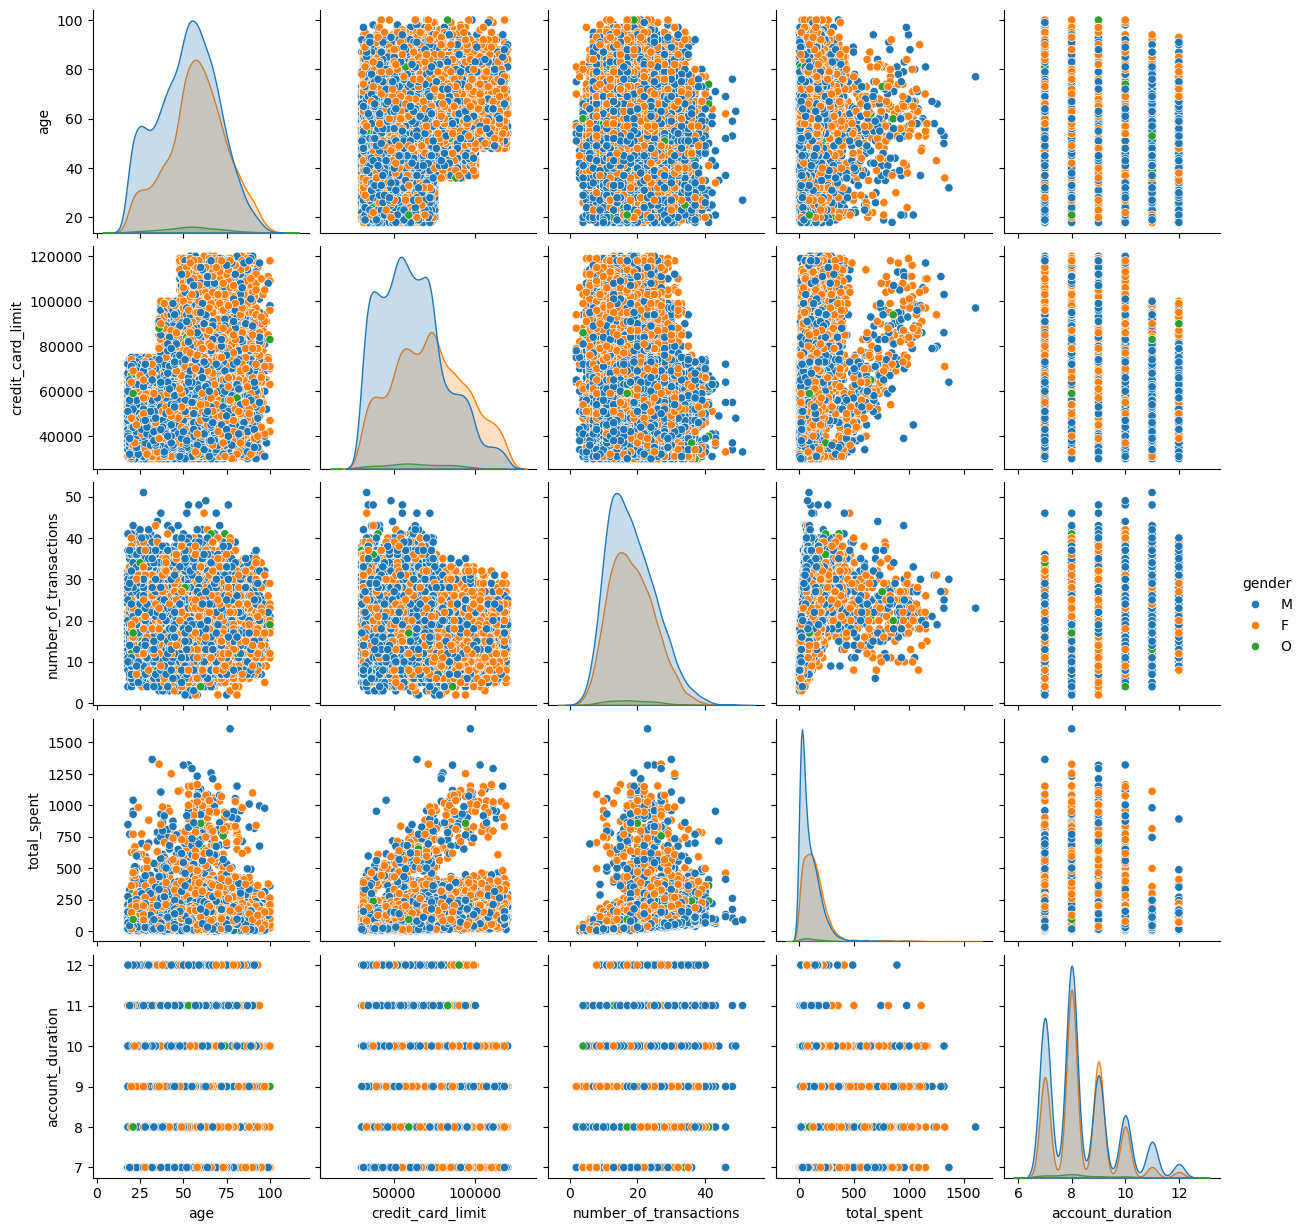

In [80]:
sns.pairplot(pdf,  hue="gender")

In [81]:
pdf[pdf['gender']=='M'].shape[0]/pdf.shape[0], pdf[pdf['gender']=='F'].shape[0]/pdf.shape[0],pdf[pdf['gender']=='O'].shape[0]/pdf.shape[0]


(0.572595342558218, 0.4130948363145461, 0.01430982112723591)

By inspecting the pairwise relationship between features of each client, we can list some findings:
- The dataset is roughly balanced across gender (~53% of male clients, ~44% of female clients and ~0.01% other clients)
- Males, females and others behave similarly with a few exceptions
- When `total_spent` is greater than ~500, there is a linear relationship with `credit_card_limit`. As higher the client's `credit_card_limit` is, the more them spent
- `total_spent` rises with the `number_of_transactions` until reaching roughly 20, beyond which further transactions are linked to a decline in `total_spent`
- There is a clear separation in `credit_card_limit` by `age`: everyone with more than 100k is at least 50 years old
- With few exceptions, `age` and `total_spent` are positively related up to about 50 years old: among clients under 50, older age is associated with higher spending; beyond 50, older age tends to correspond to lower spending
- Higher `credit_card_limit` tend to represent less `number_of_transactions`